In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from helper_functions import plot_predictions, plot_decision_boundary

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.backends.cuda.is_available() else 'cpu'
torch.set_default_device(device)
torch.manual_seed(0)
torch.mps.manual_seed(0)

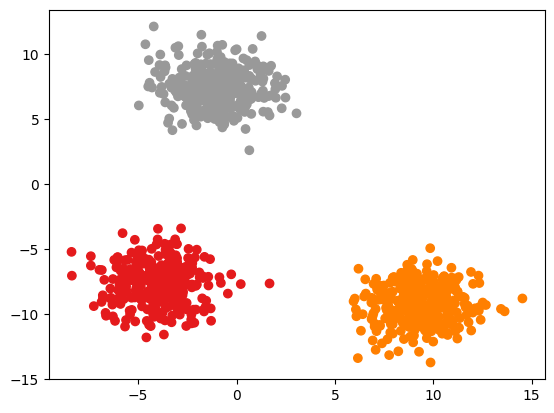

In [2]:
NUM_CLASSES = 3
NUM_FEATURES = 2

X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5,
)
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.Set1);

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    torch.tensor(X_blob, dtype=torch.float32, device=device),
    torch.tensor(y_blob, dtype=torch.float32, device=device), test_size=0.2)

In [4]:
import torch
from torch import Tensor
from torch.nn import Module, Sequential, Linear

class BlobsDeepLearnin(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.layer = Sequential(
            Linear(in_features=in_features, out_features=out_features),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.layer(x)

model = BlobsDeepLearnin(NUM_FEATURES, NUM_CLASSES)
optimizer = SGD(params=model.parameters(), lr=1e-3)
loss_fun = CrossEntropyLoss()

In [5]:
epochs = 1 + 40000

epoch_all = []
loss_all = []
test_loss_all = []
model.train()
for epoch in range(epochs):
    y_logits = model(X_train)

    loss = loss_fun(y_logits, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % int(epochs / 10) == 0:
        acc = accuracy_score(y_train.cpu(), y_logits.argmax(dim=1).cpu())
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            loss_test = loss_fun(test_logits, y_test)
            test_loss_all.append(loss_test.item())
            test_acc = accuracy_score(y_test.cpu(), test_logits.argmax(dim=1).cpu())

        epoch_all.append(epoch)
        loss_all.append(loss.item())
        print(f"epoch {epoch}, loss {loss:.5f}, acc {acc:.5f}, test loss {loss_test:.5f}, test acc {test_acc:.5f}")

print('Done')

epoch 0, loss 0.59827, acc 0.59875, test loss 0.58877, test acc 0.66000
epoch 4000, loss 0.00886, acc 1.00000, test loss 0.01196, test acc 1.00000
epoch 8000, loss 0.00517, acc 1.00000, test loss 0.00805, test acc 1.00000
epoch 12000, loss 0.00375, acc 1.00000, test loss 0.00649, test acc 1.00000
epoch 16000, loss 0.00298, acc 1.00000, test loss 0.00563, test acc 1.00000
epoch 20000, loss 0.00249, acc 1.00000, test loss 0.00507, test acc 1.00000
epoch 24000, loss 0.00215, acc 1.00000, test loss 0.00467, test acc 1.00000
epoch 28000, loss 0.00190, acc 1.00000, test loss 0.00437, test acc 1.00000
epoch 32000, loss 0.00171, acc 1.00000, test loss 0.00413, test acc 1.00000
epoch 36000, loss 0.00155, acc 1.00000, test loss 0.00394, test acc 1.00000
epoch 40000, loss 0.00143, acc 1.00000, test loss 0.00378, test acc 1.00000
Done


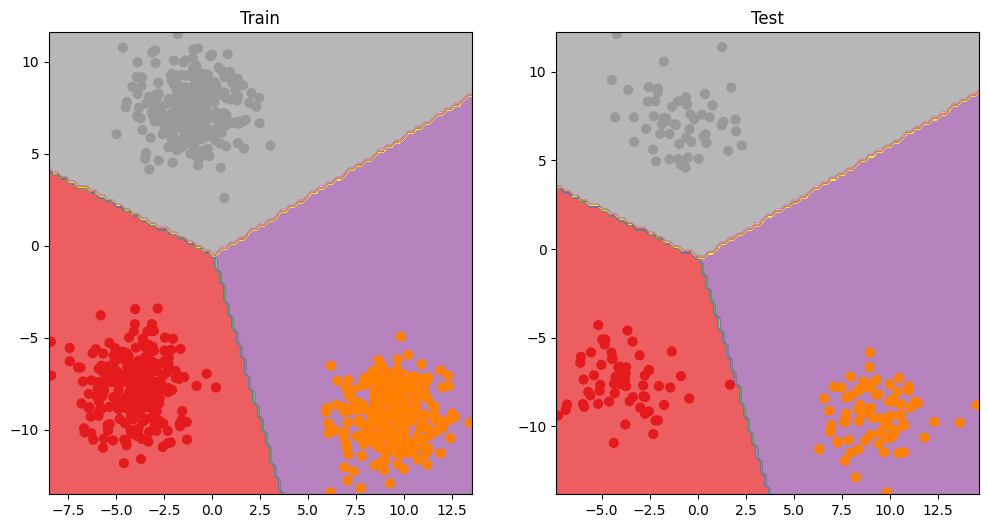

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model, X_train.cpu(), y_train.cpu())
plt.title("Train")
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test.cpu(), y_test.cpu())